In [1]:
PROJECT_NAME = "1"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image

data_dir = "/content/drive/MyDrive/OTH/space-eye/dataset/flattened_cropped"

data_gen = image.ImageDataGenerator(rescale=1./255., 
                                    zoom_range=0.1,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='nearest',
                                    validation_split=0.2)

train_gen = data_gen.flow_from_directory(data_dir,
                                         target_size=(400,400),
                                         color_mode="rgba",
                                         class_mode='binary',
                                         subset='training')

validation_gen = data_gen.flow_from_directory(data_dir,
                                         target_size=(400,400),
                                         color_mode="rgba",
                                         class_mode='binary',
                                         subset='validation')

Found 1402 images belonging to 2 classes.
Found 350 images belonging to 2 classes.


float32 (32, 400, 400, 4)
float32 (32,)


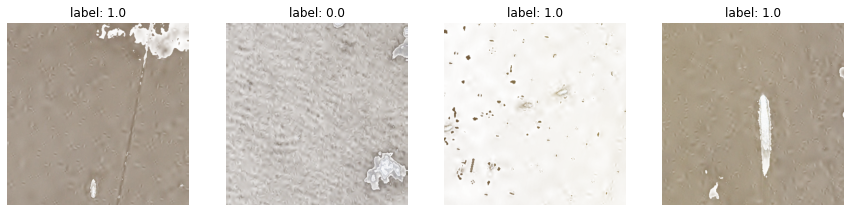

In [4]:
images_train, labels_train = next(train_gen)

print(images_train.dtype, images_train.shape)
print(labels_train.dtype, labels_train.shape)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,4, figsize=(15,15))

for e,i in enumerate([0,7,16,31]):
  img_title = 'label: ' + str(labels_train[i])
  axs[e].imshow(images_train[i]), axs[e].axis('off'), axs[e].title.set_text(img_title)

plt.show()

In [5]:
from tensorflow import keras
from functools import partial
from tensorflow.keras import layers, initializers, regularizers, Model

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def build_model():

  model = keras.Sequential([
    keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(400, 400 ,4)),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    #keras.layers.Dense(2, activation='softmax')
    keras.layers.Dense(1, activation = 'sigmoid')
  ])

  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', f1_m, metrics.Precision(), metrics.Recall()])

  return model

In [6]:
import os, time
import tensorflow as tf
from tensorflow.keras import optimizers, callbacks, metrics
import keras.backend as K

# enable tensorboard
%load_ext tensorboard

tf.keras.backend.clear_session()
log_dir = os.path.join('/content/drive/MyDrive/OTH/space-eye/project', PROJECT_NAME, 'logs', time.strftime('%d_%m_%y-%H_%M'))
learning_rate = .001 
epochs = 50

# to start tensorboard via console within the folder >> tensorboard --logdir=./tensorboard --port=6006
tensorboard_cb = callbacks.TensorBoard(log_dir)
checkpoint_cb = callbacks.ModelCheckpoint(os.path.join('/content/drive/MyDrive/OTH/space-eye/project', PROJECT_NAME, 'model'), save_best_only=True, monitor='val_loss')
early_stopping_cb = callbacks.EarlyStopping(patience=10)

model = build_model()

history = model.fit(train_gen, epochs=epochs, validation_data=validation_gen,
                    callbacks=[checkpoint_cb, tensorboard_cb, early_stopping_cb]) 

Epoch 1/50
30/44 [===================>..........] - ETA: 1:49 - loss: 1.2651 - accuracy: 0.4948 - f1_m: 0.2368 - precision: 0.4749 - recall: 0.2623

UnknownError: ignored

In [ ]:
# displays tensorboard within the notebook
%tensorboard --logdir /content/drive/MyDrive/OTH/logs

In [ ]:
from tensorflow.keras import models

mdl = models.load_model(os.path.join('/content/drive/MyDrive/OTH/space-eye/project', PROJECT_NAME, 'model')) 

y_pred = mdl.predict(X_test).ravel()

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = roc_auc_score(y_test, y_pred_keras)
f1_keras = f1_score(y_test, y_pred_keras.round().astype(int), pos_label=1, average="binary")

import matplotlib.pyplot as plt

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f}, F1 = {:.3f})'.format(auc_keras, f1_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f}, F1 = {:.3f})'.format(auc_keras, f1_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

OSError: ignored